<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

In [70]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [71]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.8.0

numpy      : 1.17.2
scipy      : 1.4.1
pandas     : 1.0.3
matplotlib : 3.2.1
statsmodels: 0.11.1
sklearn    : 0.21.3

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-62-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Git hash: 77dafa42a619730d84e03949ac152177b92bb669



In [3]:
import os
import pandas as pd
import pickle
from collections import Counter
import numpy as np

from tqdm import tqdm
tqdm.pandas()

from scipy.sparse import csr_matrix
from scipy import sparse

/home/voloch/.local/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [81]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC


import catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [5]:
import plotly.express as px

In [6]:
PATH_TO_DATA = os.path.join('./', 'data', 'compete-catch_me_if_you_can')
PATH_TO_DATA

'./data/compete-catch_me_if_you_can'

In [7]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [8]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [9]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [10]:
train_df.keys()

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'target'],
      dtype='object')

In [11]:
train_test_df = pd.concat([train_df, test_df])

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [12]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [13]:
train_test_df_sites.shape

(336358, 10)

***Создаем разреженную матрицу***

In [14]:
train_test_df_sites.reset_index(inplace=True)

In [15]:
%%time
row_csr  = []
data_csr = []
col_csr  = []

for idx in range(train_test_df_sites.shape[0]):
    for el in Counter(train_test_df_sites.loc[idx, :].values[1:]).most_common():
        row_csr.append(idx)
        data_csr.append(el[1])
        col_csr.append(el[0])
    

CPU times: user 44.6 s, sys: 61.8 ms, total: 44.7 s
Wall time: 44.1 s


In [16]:
train_test_sparse = csr_matrix((data_csr, (row_csr, col_csr)), shape=(max(row_csr)+1, max(col_csr)+1))

In [17]:
train_test_sparse.shape

(336358, 48372)

Выделяем отдельные вектора. Игнорируем колонку с сайтом 0

In [18]:
X_train_sparse = train_test_sparse[:train_df.shape[0], 1:]
X_test_sparse = train_test_sparse[train_df.shape[0] :, 1:]
y = train_df.target

In [19]:
print('was' + str(train_df.shape) + str(test_df.shape))
print(X_train_sparse.shape, X_test_sparse.shape)

was(253561, 21)(82797, 20)
(253561, 48371) (82797, 48371)


**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [20]:
print(X_train_sparse.shape, X_test_sparse.shape)

(253561, 48371) (82797, 48371)


In [21]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

In [22]:
y.shape

(253561,)

Разобьем выборки с учетом времение, не перемешивая

In [23]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [24]:
X_train.shape, y_train.shape

((177492, 48371), (177492,))

In [25]:
type(X_train), type(y_train)

(scipy.sparse.csr.csr_matrix, pandas.core.series.Series)

In [26]:
y.head()

session_id
1    0
2    0
3    0
4    0
5    0
Name: target, dtype: int64

***Пробуем обучить SGDClassifier. В начале на всей выборке и оценим точность. Затем по всей выборке и сделаем  прогноз для соревнования***

In [27]:
sgd_logit = SGDClassifier(loss = 'log', random_state = 17, n_jobs = -1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [28]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

In [29]:
logit_valid_pred_proba[:,1]

array([8.80885865e-02, 2.96493343e-04, 1.27345522e-04, ...,
       1.22481202e-02, 5.60663172e-05, 1.13147460e-02])

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [91]:
roc_auc = roc_auc_score(y_valid, logit_valid_pred_proba[:,1])
print(round(roc_auc, 3)) #, sum(predicted), sum(y_train))

0.934


In [33]:
sgd_logit_full = SGDClassifier(loss = 'log', random_state = 17, n_jobs = -1)
sgd_logit_full.fit(X_train_sparse, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [34]:
logit_valid_pred_proba_full = sgd_logit_full.predict_proba(X_test_sparse)

Сохраним и отправим на соревновние. Посмотрим результат. 'Команда' **[YDF & MIPT] Coursera_Akhremenko Vladimir**

In [35]:
write_to_submission_file(logit_valid_pred_proba_full[:, 1], 'submission_avv.csv')

текущий скор: ***0.91646***    
Первый требуемый бенчмарк уже превзойден: **0.91273 sgd_logit_benchmark.csv** 

Доступные бенчмарки

0.95965    A3 strong baseline (20 credits)    
0.95343    A3 baseline (10 credits)    
0.95216    Logit Tf-Idf 6 features    
**0.92784    Logit +3 features**    
0.92784    A3 baseline 2    
0.92692    CountVectorizer-logit-3feat    
**0.91273    sgd_logit_benchmark.csv**    
0.91252    Alice - logistic regression baseline    
0.90812    A3 baseline 1    
0.90703    CountVectorizer-logit    


# Попробуем улучшить результат и превзойти второй требуемый бенчмарк: 0.92784 Logit +3 features    
Создадим собственные признаки

In [36]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'rb')as f:
    X_train_sparse = pickle.load(f)
    
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'rb')as f:
    X_test_sparse = pickle.load(f)

In [37]:
train_df[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 
          'site7', 'site8', 'site9', 'site10']] = \
        train_df[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 
                  'site7', 'site8', 'site9', 'site10']].fillna(0).astype('int')

train_df[['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 
          'time7', 'time8', 'time9', 'time10']] =\
        train_df[['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 
                  'time7', 'time8', 'time9', 'time10']].fillna(0)

#train_df.head()

In [38]:
test_df[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 
          'site7', 'site8', 'site9', 'site10']] = \
        test_df[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 
                 'site7', 'site8', 'site9', 'site10']].fillna(0).astype('int')

test_df[['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 
          'time7', 'time8', 'time9', 'time10']] = \
        test_df[['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 
                 'time7', 'time8', 'time9', 'time10']].fillna(0)

#test_df.head()

In [39]:
site_ftrs = ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 
          'site7', 'site8', 'site9', 'site10']
time_ftrs = ['time1', 'time2','time3','time4','time5','time6',
             'time7','time8','time9','time10']
zero_dt = pd.to_datetime(0)

In [40]:
for el in time_ftrs:
    train_df[el] = pd.to_datetime(train_df[el])
    test_df[el] = pd.to_datetime(test_df[el])
    

Соберем статистики по рабочим: дням и выходным по отдельности:       
- [x] количество уникальных сайтов в сессии
- [x] длительность посещения первого сайта в сессии
- [x] длительность сессии
- [x] час начала сессии
- [x] день недели начала сессии
- [ ] длительность посещения первого сайта в день mean/std
- [ ] время входа на первый сайт в день mean/std

(галочкой отмечены фичи, участвующие в финальном решении)

In [41]:
def get_stats(inp_data, new_df, target = None):
    
    day_of_week = []
    session_timespan = []
    start_hour = []
    unique_sites = []

    # statistics per user at weekdays
    #first_day_site  = []         # first site of the day
    #first_sess_site = []         # first site in session
    weekdays_first_day_site_duration = []   # duration on first site of the day
    weekdays_first_sess_site_duration = []  # duration on first site in session
    weekdays_first_connect_in_day_time = [] # time of enter at the first site of the day
    weekdays_start_hour = []
    weekdays_unique_sites = []
    weekdays_session_timespan = []

    # statistics per user at weekends
    #first_day_site  = []         # first site of the day
    #first_sess_site = []         # first site in session
    weekend_first_day_site_duration = []   # duration on first site of the day
    weekend_first_sess_site_duration = []  # duration on first site in session
    weekend_first_connect_in_day_time = [] # time of enter at the first site of the day
    weekend_start_hour = []
    weekend_unique_sites = []
    weekend_session_timespan = []
    
    if isinstance(target, np.int):
        indexes = inp_data[inp_data.target == target].index
    else:
        indexes = inp_data.index
    
    for el in tqdm(indexes):
       
        #!!!!!!!!!! site10 == 0
        #if 0 in inp_data.loc[el, site_ftrs].unique():
        if inp_data.loc[el, 'site10'] == 0:
             uniq_sites = len(inp_data.loc[el, site_ftrs].unique()) - 1
        else:
            uniq_sites = len(inp_data.loc[el, site_ftrs].unique())
        new_df.loc[el, 'unique_sites'] = uniq_sites

        if inp_data.loc[el, 'time2'] != zero_dt:
            site_duration = (inp_data.loc[el, 'time2'] - inp_data.loc[el, 'time1']).total_seconds()
        else:
            site_duration = 0
        new_df.loc[el, 'first_sess_site_duration'] = site_duration

        for time_ftr in list(time_ftrs[::-1]):
            if inp_data.loc[el, time_ftr] != zero_dt:
                session_timespan = (inp_data.loc[el, time_ftr] - inp_data.loc[el, 'time1']).total_seconds()
                break
        new_df.loc[el, 'session_timespan'] = session_timespan 

        #if (train_df.loc[el, 'time1'].weekday() == 5) or ((train_df.loc[el, 'time1'].weekday() == 6)):
        if (new_df.loc[el, 'dow'] == 5) or ((new_df.loc[el, 'dow'] == 6)):
            weekend_unique_sites.append(uniq_sites)   
            weekend_first_sess_site_duration.append(site_duration)
            weekend_start_hour.append(new_df.loc[el, 'start_hour'])
            weekend_session_timespan.append(session_timespan)
        else:
            weekdays_unique_sites.append(uniq_sites)
            weekdays_first_sess_site_duration.append(site_duration)
            weekdays_start_hour.append( new_df.loc[el, 'start_hour'])
            weekdays_session_timespan.append( session_timespan )

    stat_dict = {'weekend_unique_sites_mean' : np.mean(weekend_unique_sites)
                         ,'weekend_unique_sites_std' : np.std(weekend_unique_sites)
                         ,'weekend_first_sess_site_duration_mean' : np.mean(weekend_first_sess_site_duration)
                         ,'weekend_first_sess_site_duration_std' : np.std(weekend_first_sess_site_duration)
                         ,'weekend_start_hour_mean' : np.mean(weekend_start_hour)
                         ,'weekend_start_hour_std' : np.std(weekend_start_hour)
                         ,'weekend_session_timespan_mean' : np.mean(weekend_session_timespan)
                         ,'weekend_session_timespan_std' : np.std(weekend_session_timespan)

                         ,'weekdays_unique_sites_mean' : np.mean(weekdays_unique_sites)
                         ,'weekdays_unique_sites_std' : np.std(weekdays_unique_sites)
                         ,'weekdays_first_sess_site_duration_mean' : np.mean(weekdays_first_sess_site_duration)
                         ,'weekdays_first_sess_site_duration_std' : np.std(weekdays_first_sess_site_duration)
                         ,'weekdays_start_hour_mean' : np.mean(weekdays_start_hour)
                         ,'weekdays_start_hour_std' : np.std(weekdays_start_hour)
                         ,'weekdays_session_timespan_mean' : np.mean(weekdays_session_timespan)
                         ,'weekdays_session_timespan_std' : np.std(weekdays_session_timespan)    
                         }
    return new_df, stat_dict

In [42]:
def get_stats_sparse(inp_data, sparse_data):
    
    tmp_df = pd.DataFrame(index = inp_data.index)
    tmp_df['start_hour'] = inp_data['time1'].map(lambda x: x.hour)
    tmp_df['dow'] = inp_data['time1'].map(lambda x: x.weekday())
    
    tmp_df, stat_dict_0 = get_stats(inp_data, tmp_df, 0)
    tmp_df, stat_dict_1 = get_stats(inp_data, tmp_df, 1)
    
    return sparse_data, tmp_df, stat_dict_0, stat_dict_1

In [43]:
%%time
# 16min 26s
X_train_sparse, train_df_add, other_stats, Alice_stats = get_stats_sparse(train_df, X_train_sparse)

100%|██████████| 2297/2297 [00:09<00:00, 250.60it/s]

CPU times: user 16min 7s, sys: 2.18 s, total: 16min 9s
Wall time: 16min 2s


In [44]:
%%time 
for el in time_ftrs:
    test_df[el] = pd.to_datetime(test_df[el])

tst_df = pd.DataFrame(index = test_df.index)
tst_df['start_hour'] = test_df['time1'].map(lambda x: x.hour)
tst_df['dow'] = test_df['time1'].map(lambda x: x.weekday())
    
test_df_add, _ = get_stats(test_df, tst_df)

100%|██████████| 82797/82797 [02:43<00:00, 507.95it/s]

CPU times: user 2min 43s, sys: 401 ms, total: 2min 44s
Wall time: 2min 43s


In [ ]:
#Alice_stats

In [46]:
with open(os.path.join(PATH_TO_DATA, 'alice_stats.pkl'), 'wb') as af:
    pickle.dump(Alice_stats, af, protocol=2)
    
with open(os.path.join(PATH_TO_DATA, 'other_stats.pkl'), 'wb') as of:
    pickle.dump(other_stats, of, protocol=2)
    
with open(os.path.join(PATH_TO_DATA, 'X_train.pkl'), 'wb') as xf:
    pickle.dump(X_train, xf, protocol=2)


Преобразуем категориальные фичи

In [47]:
lb_dow = LabelBinarizer().fit(train_df_add.dow)
lb_start_hour  = LabelBinarizer().fit(train_df_add.start_hour)
lb_unique_site = LabelBinarizer().fit(train_df_add.unique_sites)

Объеденим собранные данные в итоговые матрицы

In [48]:
X_train_sparse_v2 = sparse.hstack((X_train_sparse, np.array(train_df_add.first_sess_site_duration)[:,None]))
X_test_sparse_v2  = sparse.hstack((X_test_sparse,  np.array(test_df_add.first_sess_site_duration)[:,None]))

X_train_sparse_v2 = sparse.hstack((X_train_sparse_v2, np.array(train_df_add.session_timespan.values)[:,None]))
X_test_sparse_v2  = sparse.hstack((X_test_sparse_v2,  np.array(test_df_add.session_timespan.values)[:,None]))

X_train_sparse_v2 = sparse.hstack((X_train_sparse_v2, 
                                   csr_matrix(lb_dow.transform(train_df_add.dow.values))))
X_test_sparse_v2  = sparse.hstack((X_test_sparse_v2,  
                                   csr_matrix(lb_dow.transform(test_df_add.dow.values))))

X_train_sparse_v2 = sparse.hstack((X_train_sparse_v2, 
                                   csr_matrix(lb_start_hour.transform(train_df_add.start_hour.values))))
X_test_sparse_v2  = sparse.hstack((X_test_sparse_v2,  
                                   csr_matrix(lb_start_hour.transform(test_df_add.start_hour.values))))

X_train_sparse_v2 = sparse.hstack((X_train_sparse_v2, 
                                   csr_matrix(lb_unique_site.transform(train_df_add.unique_sites.values))))
X_test_sparse_v2  = sparse.hstack((X_test_sparse_v2,  
                                   csr_matrix(lb_unique_site.transform(test_df_add.unique_sites.values))))


In [49]:
%%time
with open(os.path.join(PATH_TO_DATA, 'X_train.pkl'), 'rb') as xf:
    X_train = pickle.load(xf)
    
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

CPU times: user 18.5 ms, sys: 4 ms, total: 22.5 ms
Wall time: 21.1 ms


In [50]:
%%time
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_sparse_v2, y, test_size=0.33, random_state=944)

CPU times: user 59.6 ms, sys: 4.01 ms, total: 63.6 ms
Wall time: 62.5 ms


Так же попробуем оценить количество сессий Alice в LB на Kaggle.    
Так как у нас других данных нет, за оценку возьмем пропорцию в тестовой выборке:    

In [76]:
proportion = sum(y)/X_train_sparse_v2.shape[0]
proportion

0.00905896411514389

In [77]:
str(int(X_test_sparse_v2.shape[0] * proportion)) + ' from ' + str(X_test_sparse_v2.shape[0])

'750 from 82797'

***750*** - это для нас удинственный ориентир, который мы имеем

***Обучим SGDClassifier на расширенных данных***

In [51]:
clf_sgd_part = SGDClassifier(loss = 'log', random_state = 17, n_jobs = -1)
clf_sgd_part.fit(X_tr, y_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [52]:
clf_sgd_valid_pred_proba = clf_sgd_part.predict_proba(X_val)
roc_auc_score(y_val, clf_sgd_valid_pred_proba[:,1])

0.9008723354812488

Как мы видим, результат даже немного ухудшился. В основном из-за того, что мы отошли от сортироваки по времени    
и разбили данные на train и test через train_test_split.    
Более того, даже изменяя random_state на отличный от 17 мы понижаем результат.    
На Kaggele результат так же понижается, что выглядит несколько странным.

Сделаем предположение, что это в силу стохастической природы SGDClassifier.
Попробуем заменить его на другие классификаторы.

***Будм пробовать классификаторы: SGDClassifier, LogisticRegression, RandomForestClassifier, CatBoostClassifier, LighGBM.    
Так же попробуем повысить вес класса  Alice***

In [149]:
clf_sgd = SGDClassifier(loss = 'log', random_state = 17, n_jobs = -1, class_weight={0:0.4, 1: 0.6})
clf_sgd.fit(X_train_sparse_v2, y)

predicted_sgd = clf_sgd.predict_proba(X_train_sparse_v2)
roc_auc_sgd = roc_auc_score(y, predicted_sgd[:,1])

pred_sgd = clf_sgd.predict(X_train_sparse_v2)
pred_sgd_subm = clf_sgd.predict(X_test_sparse_v2)

print(roc_auc_sgd, sum(pred_sgd), sum(y), sum(pred_sgd_subm))

0.9073209180461081 1278 2297 362


In [115]:
clf_sgd_pred_proba = clf_sgd.predict_proba(X_test_sparse)

In [116]:
write_to_submission_file(clf_sgd_pred_proba[:, 1], 'subm_avv_sgd_5ftrs2.csv')

In [147]:
%%time
clfLR = LogisticRegression(random_state=17, n_jobs=-1, class_weight={0:0.4, 1: 0.6})
clfLR.fit(X_train_sparse_v2, y)

pred_LR = clfLR.predict_proba(X_train_sparse_v2)
roc_auc_LR = roc_auc_score(y, pred_LR[:,1])

pred_LR = clfLR.predict(X_train_sparse_v2)
pred_LR_test = clfLR.predict(X_test_sparse_v2)

print(roc_auc_LR, sum(pred_LR), sum(y), sum(pred_LR_test))

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.



0.9923592186429573 1525 2297 347
CPU times: user 22.7 s, sys: 320 ms, total: 23.1 s
Wall time: 6.03 s


In [150]:
predicted_LR = clfLR.predict_proba(X_test_sparse_v2)
write_to_submission_file(predicted_LR[:, 1], 'subm_avv_lr_5ftrs_w_4_6.csv')

In [154]:
%%time 
# 3min 3s
#  1min 27s

#clfRF = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, random_state=17)
clfRF = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=17, class_weight={0:0.4, 1: 0.6})
clfRF.fit(X_train_sparse_v2, y)

pred_RF = clfRF.predict_proba(X_train_sparse_v2)
roc_auc_RF = roc_auc_score(y, pred_RF[:,1])

pred_RF = clfRF.predict(X_train_sparse_v2)
pred_RF_test = clfRF.predict(X_test_sparse_v2)

print(roc_auc_RF, sum(pred_RF), sum(y), sum(pred_RF_test))

0.9999949484834368 2096 2297 69
CPU times: user 1min 2s, sys: 1.93 s, total: 1min 4s
Wall time: 18.8 s


In [151]:
predicted_RF = clfRF.predict_proba(X_test_sparse_v2)
write_to_submission_file(predicted_RF[:, 1], 'subm_avv_rf_5ftrs_w_4_6.csv')

In [90]:
%%time 

clf_lgbm = LGBMClassifier(class_weight={0:0.4, 1: 0.6}, n_estimators=25)
clf_lgbm.fit(X_train_sparse_v2, y)

pred_lgbm = clf_lgbm.predict_proba(X_train_sparse_v2)
roc_auc_lgbm = roc_auc_score(y, pred_lgbm[:,1])

pred_lgbm = clf_lgbm.predict(X_train_sparse_v2)
pred_lgbm_test = clf_lgbm.predict(X_test_sparse_v2)

print(roc_auc_lgbm, sum(pred_lgbm), sum(y), sum(pred_lgbm_test))

/home/voloch/Anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:597: UserWarning:

Converting data to scipy sparse matrix.



0.9916571739276641 1557 2297 295
CPU times: user 19.9 s, sys: 103 ms, total: 20 s
Wall time: 5.42 s


In [88]:
pred_lgbm_test = clf_lgbm.predict(X_test_sparse_v2)
write_to_submission_file(pred_lgbm_test, 'subm_avv_lgbm_5ftrs_w_4_6.csv')

In [53]:
ctb_clf = CatBoostClassifier(loss_function='Logloss', class_weights=[0.4, 0.6])
ctb_clf.fit(X_train_sparse_v2, y)

Learning rate set to 0.109516
0:	learn: 0.4919673	total: 162ms	remaining: 2m 41s
1:	learn: 0.3566479	total: 264ms	remaining: 2m 11s
2:	learn: 0.2666527	total: 367ms	remaining: 2m 1s
3:	learn: 0.1930372	total: 478ms	remaining: 1m 59s
4:	learn: 0.1463142	total: 607ms	remaining: 2m
5:	learn: 0.1180761	total: 709ms	remaining: 1m 57s
6:	learn: 0.1019427	total: 815ms	remaining: 1m 55s
7:	learn: 0.0881156	total: 931ms	remaining: 1m 55s
8:	learn: 0.0765114	total: 1.06s	remaining: 1m 57s
9:	learn: 0.0712002	total: 1.17s	remaining: 1m 55s
10:	learn: 0.0653854	total: 1.28s	remaining: 1m 55s
11:	learn: 0.0620510	total: 1.4s	remaining: 1m 54s
12:	learn: 0.0571672	total: 1.53s	remaining: 1m 55s
13:	learn: 0.0542781	total: 1.64s	remaining: 1m 55s
14:	learn: 0.0531439	total: 1.76s	remaining: 1m 55s
15:	learn: 0.0500442	total: 1.88s	remaining: 1m 55s
16:	learn: 0.0488125	total: 2.01s	remaining: 1m 56s
17:	learn: 0.0482063	total: 2.12s	remaining: 1m 55s
18:	learn: 0.0467036	total: 2.24s	remaining: 1m 55

In [54]:
pred_cb = ctb_clf.predict_proba(X_train_sparse_v2)
roc_auc_cb = roc_auc_score(y, pred_cb[:, 1])

pred_cb = ctb_clf.predict(X_train_sparse_v2)
pred_cb_test = ctb_clf.predict(X_test_sparse_v2)

print(roc_auc_cb, sum(pred_cb), sum(y), sum(pred_cb_test))

0.9965801137572076 1986 2297 249


In [160]:
ctb_pred = ctb_clf.predict_proba(X_test_sparse_v2)

In [161]:
write_to_submission_file(ctb_pred[:, 1], 'subm_avv_ctb_5ftrs_w_4_6.csv')

Как мы видим, все методы, основанные на деревьях очень быстро находят критически важные признаки и в моменте переобучаются даже при малом количестве n_estimtors. Даже без кросс валидации видно, что в прогнозе они дают малое количество сессии (по отношению к нашему прогнозу в ~750) для Alice.    

Так же сильное изменение весов класса приводило к тому, что алгоритмы выдавали сильно большое число сессий для Alice - порядка десятка тысяч из 82000+. Остановился на class_weight={0:0.4, 1: 0.6}.

Лучший результат из опробованных алгоритмов дал LogisticRegression с измененными весами class_weight={0:0.4, 1: 0.6}.
Как мы знаем, его можно еще улучшить через оптимизацию параметра С. Мы не будем этого делать, т.к. полученный результат ***0.94474*** позволяет опередить второй требуемый бенчмарк ***0.92784 Logit +3 features***

**[лидерборд](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).** (текущее место 2220)

In [10]:
for el in time_ftrs:
    train_df[el] = pd.to_datetime(train_df[el])
    test_df[el] = pd.to_datetime(test_df[el])

In [11]:
train_df['start_hour'] = train_df['time1'].map(lambda x: x.hour)
train_df['dow'] = train_df['time1'].map(lambda x: x.weekday())

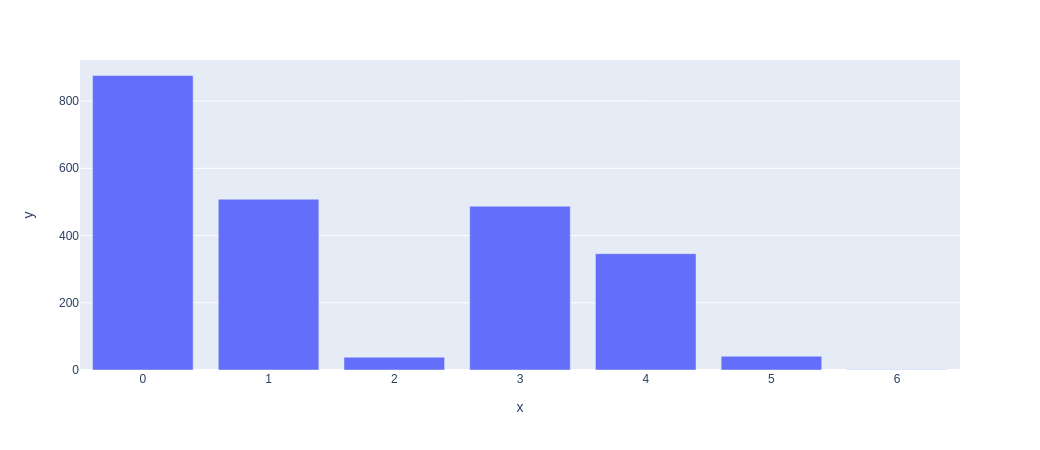

In [25]:
px.bar(x = train_df[train_df.target == 1].dow.value_counts().keys()
      , y = train_df[train_df.target == 1].dow.value_counts()
      )

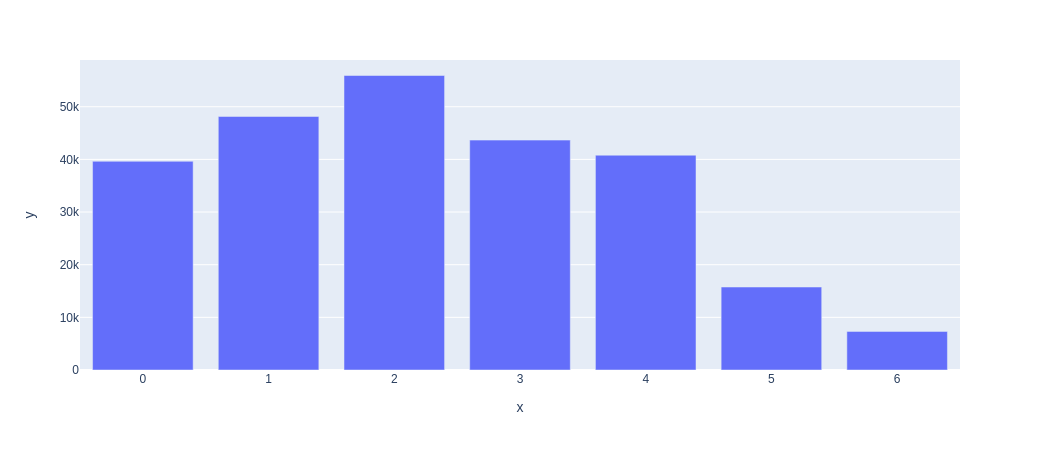

In [26]:
px.bar(x = train_df[train_df.target == 0].dow.value_counts().keys()
      , y = train_df[train_df.target == 0].dow.value_counts()
      )

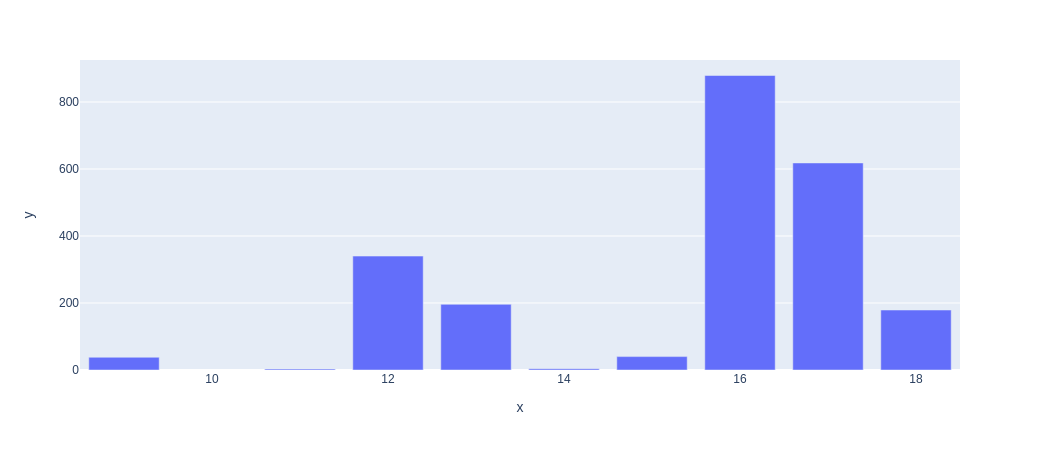

In [27]:
px.bar(x = train_df[train_df.target == 1].start_hour.value_counts().keys()
      , y = train_df[train_df.target == 1].start_hour.value_counts()
      )

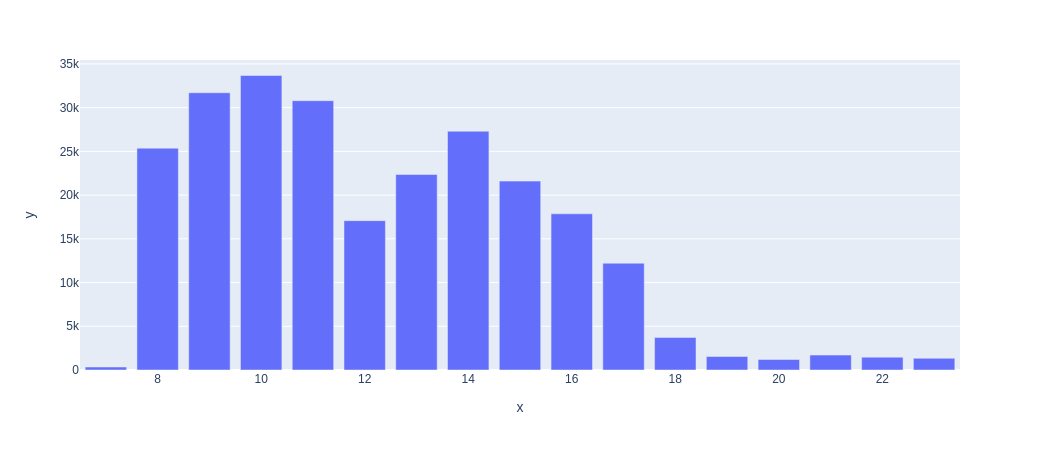

In [28]:
px.bar(x = train_df[train_df.target == 0].start_hour.value_counts().keys()
      , y = train_df[train_df.target == 0].start_hour.value_counts()
      )

In [37]:
train_df_add.keys()

Index(['start_hour', 'dow', 'unique_sites', 'first_sess_site_duration',
       'session_timespan'],
      dtype='object')

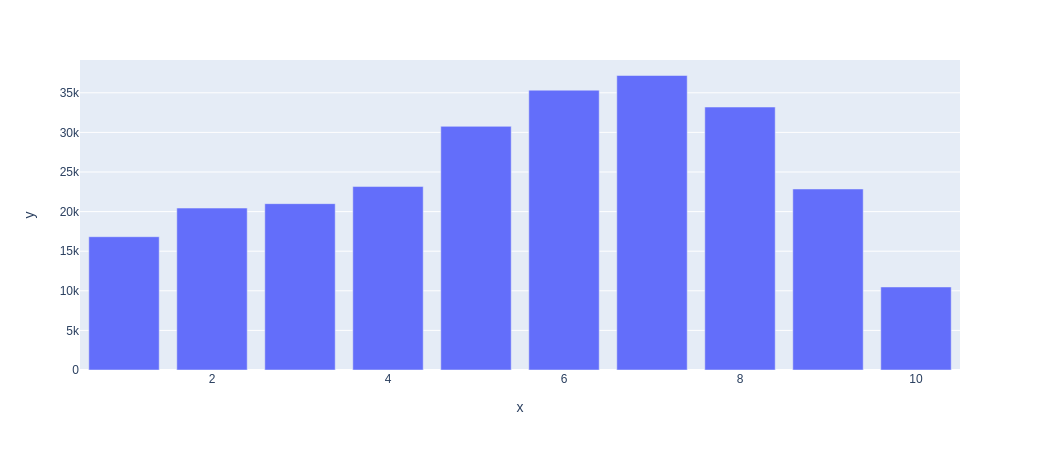

In [39]:
px.bar(x = train_df_add[train_df.target == 0].unique_sites.value_counts().keys()
      , y = train_df_add[train_df.target == 0].unique_sites.value_counts()
      )

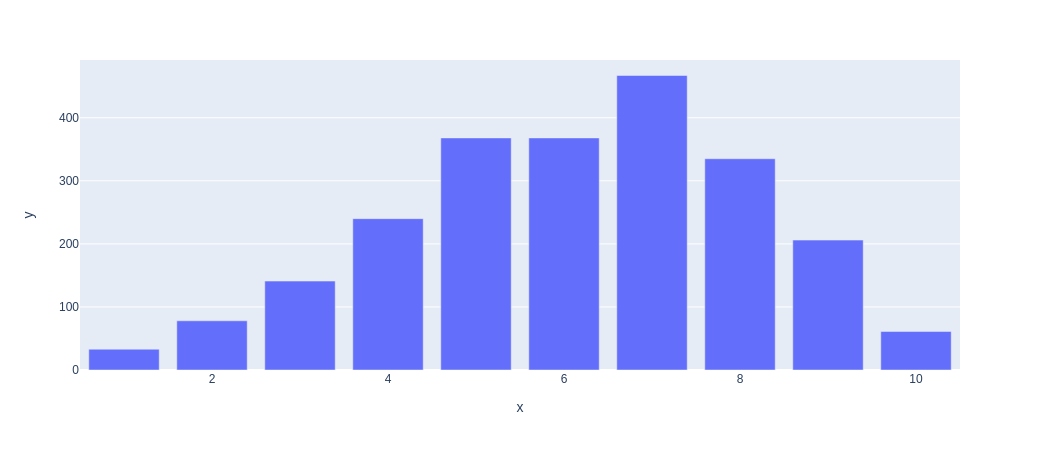

In [40]:
px.bar(x = train_df_add[train_df.target == 1].unique_sites.value_counts().keys()
      , y = train_df_add[train_df.target == 1].unique_sites.value_counts()
      )

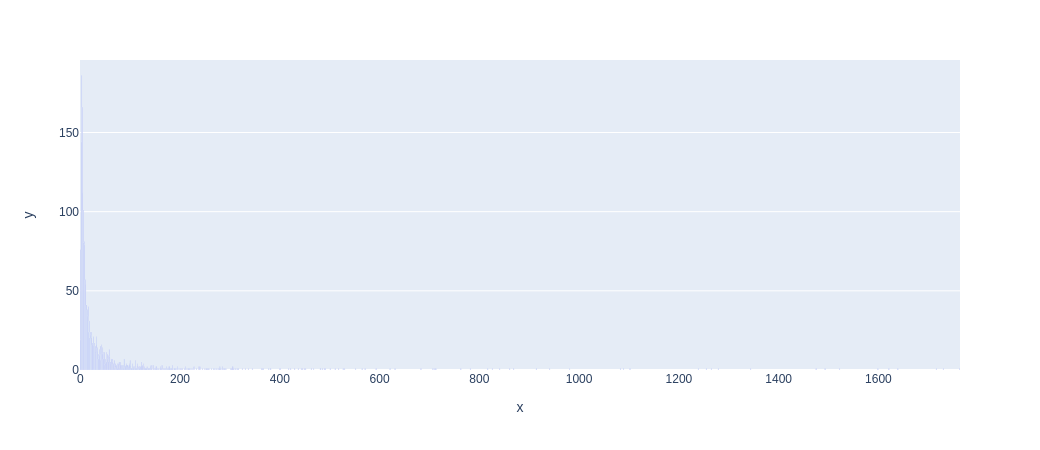

In [42]:
px.bar(x = train_df_add[train_df.target == 1].session_timespan.value_counts().keys()
      , y = train_df_add[train_df.target == 1].session_timespan.value_counts()
      )

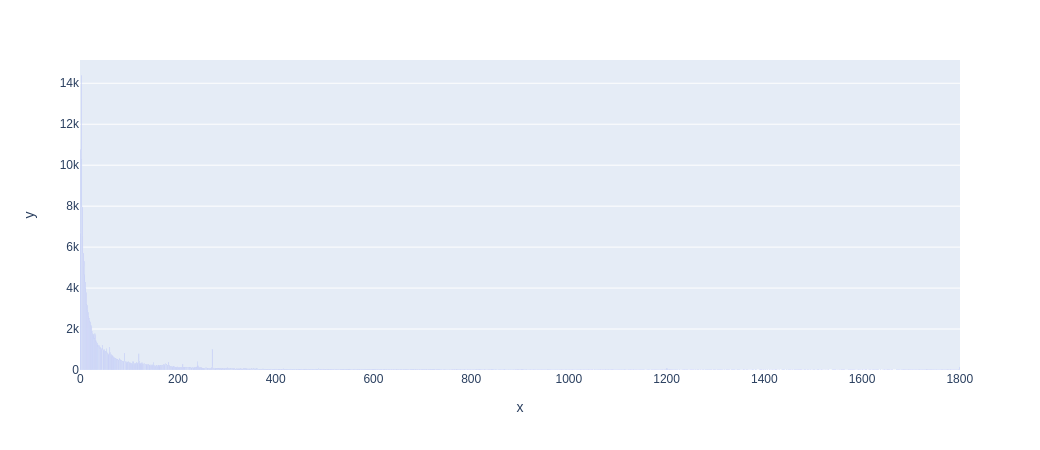

In [43]:
px.bar(x = train_df_add[train_df.target == 0].session_timespan.value_counts().keys()
      , y = train_df_add[train_df.target == 0].session_timespan.value_counts()
      )

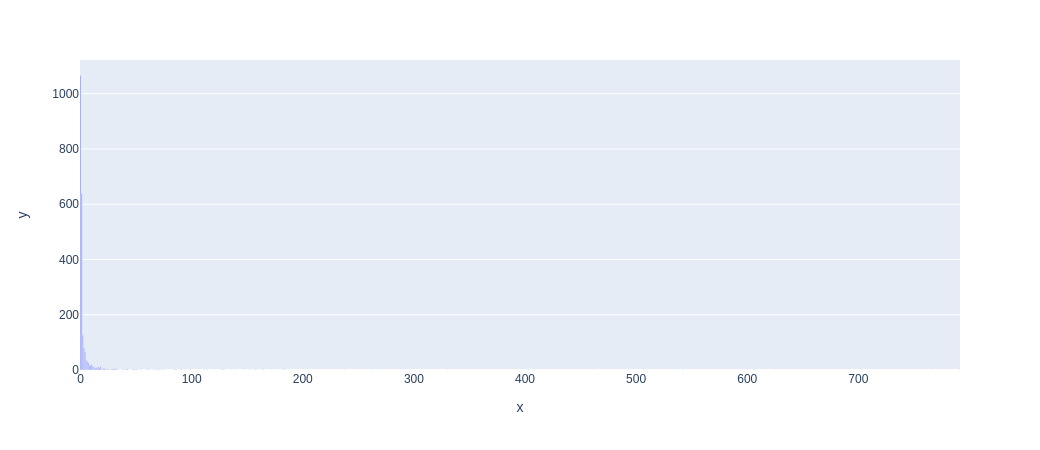

In [44]:
px.bar(x = train_df_add[train_df.target == 1].first_sess_site_duration.value_counts().keys()
      , y = train_df_add[train_df.target == 1].first_sess_site_duration.value_counts()
      )

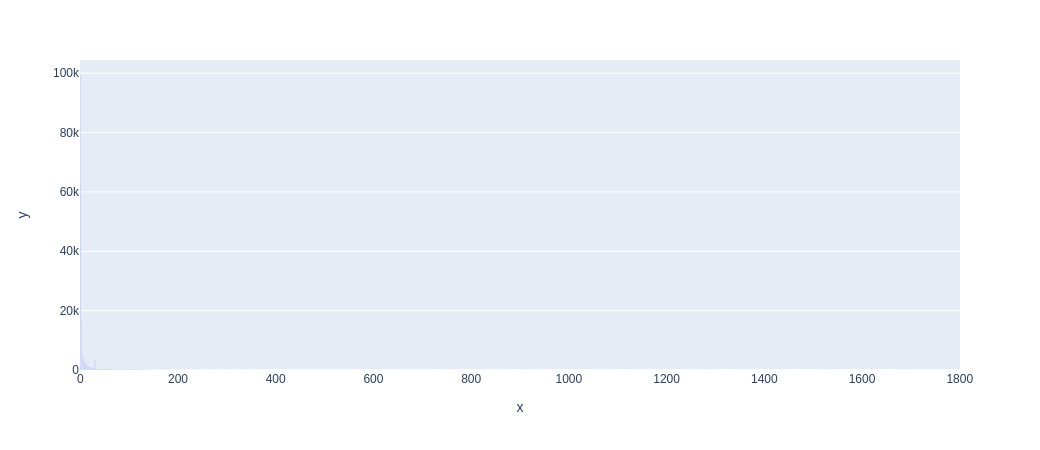

In [45]:
px.bar(x = train_df_add[train_df.target == 0].first_sess_site_duration.value_counts().keys()
      , y = train_df_add[train_df.target == 0].first_sess_site_duration.value_counts()
      )